In [26]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import ccg_filter
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

font = {'weight' : 'bold', 'size' : 14}
matplotlib.rc('font', **font)

# Define functions

In [27]:
def decimalDate_ymd (year, month, day=15):
    """ Convert a date to a fractional year. """
    pd_date = pd.to_datetime(year*10000 + month*100 + day, format='%Y%m%d')
    
    return pd_date.dt.year + pd_date.dt.dayofyear / [366 if x else 365 for x in pd_date.dt.is_leap_year]

In [28]:
def decimalDate_datetime (datetime):
    """ Convert a date to a fractional year. """
    
    return datetime.dt.year + datetime.dt.dayofyear / [366 if x else 365 for x in datetime.dt.is_leap_year]

In [29]:
def grid_area (resolution=0.5):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees."""
    # Calculations needs to be in radians
    lats = np.deg2rad(np.arange(-90,90+resolution, resolution))
    r_sq = 6371000**2
    n_lats = int(360./resolution) 
    area = r_sq*np.ones(n_lats)[:, None]*np.deg2rad(resolution)*(
                np.sin(lats[1:]) - np.sin(lats[:-1]))
    return area.T

In [30]:
def zonal_mean(df, zonal_deg, dat_cols, lat_col = "lat"):
    """ Latitude zonal average """
    
    lat_range = range(-90,90,zonal_deg)
    df_zonal_raw = pd.DataFrame()
    
    for i in lat_range:
        lat_id = (i < df[lat_col]) & (df[lat_col] <= i+zonal_deg)
        temp_raw = df.loc[lat_id,:]
        df_zonal_raw = pd.concat([df_zonal_raw,  pd.DataFrame(temp_raw[dat_cols].mean()).T] )

    df_zonal_raw["lat"] = [str(i) + "_" + str(i+zonal_deg)  for i in lat_range]
    cols_new = df_zonal_raw.columns.to_list()
    cols_new = cols_new[-1:] + cols_new[:-1]
    df_zonal_raw = df_zonal_raw.loc[:,cols_new]
    df_zonal_raw = df_zonal_raw.iloc[::-1] 
    df_zonal_raw = df_zonal_raw.set_index(["lat"])
    return df_zonal_raw

In [31]:
WDCGG_PATH = "../data/wdcgg_obs/"
CTRACKER_OBS_PATH = "../data/ctracker_obs/"
CTRACKER_MODEL_PATH = "../data/ctracker_model/"
OUT_PATH = "../data/comparison/"


# Comparison in methods and data 
- # [1. CarbonTracker obsversion vs WDCGG observation in 49 common stations (NOAA method, 2000-2017)](#ctracker_obs_wdcgg_obs)
- # [2. CarbonTracker model vs WDCGG observation in 129 common stations (NOAA method, 2000-2017)](#ctracker_model_wdcgg_obs)
- # [3. CarbonTracker model vs CarbonTracker observation in 182 common stations (NOAA method, 2000-2017)](#ctracker_model_ctracker_obs)
- # [4. NOAA method vs WDCGG method when applied to WDCGG 129 observations (1968-2017)](#noaa_mikio_wdcgg)
- # [5. NOAA method applied to CarbonTracker model vs WDCGG method applied to WDCGG observation in 129 common stations (2000-2017)](#noaa_mikio_ctracker_wdcgg)


<a name="ctracker_obs_wdcgg_obs"></a>
# 1. The NOAA method applied to different data sources (ctracker observation and wdcgg observation) in 49 common stations, 2000-2017

In [32]:
# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

# read data, and format lon and lat to float with two decimals
df_wdcgg_raw = pd.read_csv(WDCGG_PATH + "df_co2_raw_wdcgg_obs_noaa_from2000.csv")
df_wdcgg_raw.lon = df_wdcgg_raw.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_wdcgg_raw.lat = df_wdcgg_raw.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)

df_wdcgg_cal = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_noaa_from2000.csv")
df_wdcgg_cal.lon = df_wdcgg_cal.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_wdcgg_cal.lat = df_wdcgg_cal.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)

df_wdcgg_co2rate = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_noaa_from2000.csv")
df_wdcgg_co2rate.lon = df_wdcgg_co2rate.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_wdcgg_co2rate.lat = df_wdcgg_co2rate.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)

df_ctracker_raw = pd.read_csv(CTRACKER_OBS_PATH + "df_co2_raw_ctracker_obs.csv")
df_ctracker_raw.lon = df_ctracker_raw.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_ctracker_raw.lat = df_ctracker_raw.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)

df_ctracker_cal = pd.read_csv(CTRACKER_OBS_PATH + "df_co2_cal_ctracker_obs.csv")
df_ctracker_cal.lon = df_ctracker_cal.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_ctracker_cal.lat = df_ctracker_cal.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)

df_ctracker_co2rate = pd.read_csv(CTRACKER_OBS_PATH + "df_co2rate_cal_ctracker_obs.csv")
df_ctracker_co2rate.lon = df_ctracker_co2rate.lon.apply( lambda x : '{:.2f}'.format(x) if (x >=-180 and x <= 180) else np.nan).astype(float)
df_ctracker_co2rate.lat = df_ctracker_co2rate.lat.apply( lambda x : '{:.2f}'.format(x) if (x >=-90 and x <= 90) else np.nan).astype(float)


In [33]:
# find common grids
index_common_ctracker = []
index_common_wdcgg = []

for i in range(df_ctracker_raw.shape[0]):
    for j in range(df_wdcgg_raw.shape[0]):
        cond1 = abs(df_ctracker_raw.loc[i].lon - df_wdcgg_raw.loc[j].lon) <0.01
        cond2 = abs(df_ctracker_raw.loc[i].lat - df_wdcgg_raw.loc[j].lat) <0.01
        if cond1 and cond2:
            index_common_ctracker.append(i)
            index_common_wdcgg.append(j) 

df_wdcgg_raw_common = df_wdcgg_raw.loc[index_common_wdcgg]
df_wdcgg_cal_common = df_wdcgg_cal.loc[index_common_wdcgg]
df_wdcgg_co2rate_common = df_wdcgg_co2rate.loc[index_common_wdcgg]

df_ctracker_raw_common = df_ctracker_raw.loc[index_common_ctracker]
df_ctracker_cal_common = df_ctracker_cal.loc[index_common_ctracker]
df_ctracker_co2rate_common = df_ctracker_co2rate.loc[index_common_ctracker]

# save files
df_wdcgg_raw_common.to_csv(OUT_PATH+"df_wdcgg_raw_common.csv", header=True, index=False, na_rep="NaN")
df_wdcgg_cal_common.to_csv(OUT_PATH+"df_wdcgg_cal_common.csv", header=True, index=False, na_rep="NaN")
df_wdcgg_co2rate_common.to_csv(OUT_PATH+"df_wdcgg_co2rate_common.csv", header=True, index=False, na_rep="NaN")

df_ctracker_raw_common.to_csv(OUT_PATH+"df_ctracker_raw_common.csv", header=True, index=False, na_rep="NaN")
df_ctracker_cal_common.to_csv(OUT_PATH+"df_ctracker_cal_common.csv", header=True, index=False, na_rep="NaN")
df_ctracker_co2rate_common.to_csv(OUT_PATH+"df_ctracker_co2rate_common.csv", header=True, index=False, na_rep="NaN")

In [34]:
# 1.1. Calculate zonal and global co2 average over each 30 degree latitudinal band using common 49 stations
df_ctracker_raw_common = pd.read_csv(OUT_PATH + "df_ctracker_raw_common.csv")
df_ctracker_cal_common = pd.read_csv(OUT_PATH + "df_ctracker_cal_common.csv")
df_ctracker_co2rate_common = pd.read_csv(OUT_PATH + "df_ctracker_co2rate_common.csv")

df_wdcgg_raw_common = pd.read_csv(OUT_PATH + "df_wdcgg_raw_common.csv")
df_wdcgg_cal_common = pd.read_csv(OUT_PATH + "df_wdcgg_cal_common.csv")
df_wdcgg_co2rate_common = pd.read_csv(OUT_PATH + "df_wdcgg_co2rate_common.csv")

# zonal mean
zonal_deg = 30

df_zonal_raw_ctracker = zonal_mean(df_ctracker_raw_common, zonal_deg, df_ctracker_raw_common.columns[4:], "lat")
df_zonal_cal_ctracker = zonal_mean(df_ctracker_cal_common, zonal_deg, df_ctracker_cal_common.columns[4:], "lat")
df_zonal_co2rate_ctracker = zonal_mean(df_ctracker_co2rate_common, zonal_deg, df_ctracker_co2rate_common.columns[4:], "lat")
df_zonal_raw_wdcgg = zonal_mean(df_wdcgg_raw_common, zonal_deg, df_wdcgg_raw_common.columns[4:], "lat")
df_zonal_cal_wdcgg = zonal_mean(df_wdcgg_cal_common, zonal_deg, df_wdcgg_cal_common.columns[4:], "lat")
df_zonal_co2rate_wdcgg = zonal_mean(df_wdcgg_co2rate_common, zonal_deg, df_wdcgg_co2rate_common.columns[4:], "lat")

# nan index, some zonal band can be no observation data
nanindex_raw_ctracker  = df_zonal_raw_ctracker.apply(np.isnan)
nanindex_cal_ctracker  = df_zonal_cal_ctracker.apply(np.isnan)
nanindex_co2rate_ctracker  = df_zonal_co2rate_ctracker.apply(np.isnan)
nanindex_raw_wdcgg  = df_zonal_raw_wdcgg.apply(np.isnan)
nanindex_cal_wdcgg  = df_zonal_cal_wdcgg.apply(np.isnan)
nanindex_co2rate_wdcgg  = df_zonal_co2rate_wdcgg.apply(np.isnan)

nanindex_raw = nanindex_raw_wdcgg | nanindex_raw_ctracker
nanindex_cal = nanindex_cal_wdcgg | nanindex_cal_ctracker
nanindex_co2rate = nanindex_co2rate_wdcgg | nanindex_co2rate_ctracker

df_zonal_raw_ctracker = df_zonal_raw_ctracker[~nanindex_raw]
df_zonal_cal_ctracker = df_zonal_cal_ctracker[~nanindex_cal]
df_zonal_co2rate_ctracker = df_zonal_co2rate_ctracker[~nanindex_co2rate]
df_zonal_raw_wdcgg = df_zonal_raw_wdcgg[~nanindex_raw]
df_zonal_cal_wdcgg = df_zonal_cal_wdcgg[~nanindex_cal]
df_zonal_co2rate_wdcgg = df_zonal_co2rate_wdcgg[~nanindex_co2rate]

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_raw_ctracker.index)
NH_weight = NH_weight.set_axis(df_zonal_raw_ctracker.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw_ctracker.index[3:])

# global area weighted average, ctracker
global_co2_raw = df_zonal_raw_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_ctracker = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                                 global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_ctracker.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                               "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_ctracker["year"] = df_datetime.date.dt.year.tolist()

co2_annual_ctracker = co2_monthly_ctracker.groupby(["year"]).mean().T

# global area weighted average, wdcgg
global_co2_raw = df_zonal_raw_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_wdcgg = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                              global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_wdcgg.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                            "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_wdcgg["year"] = df_datetime.date.dt.year.tolist()

co2_annual_wdcgg = co2_monthly_wdcgg.groupby(["year"]).mean().T


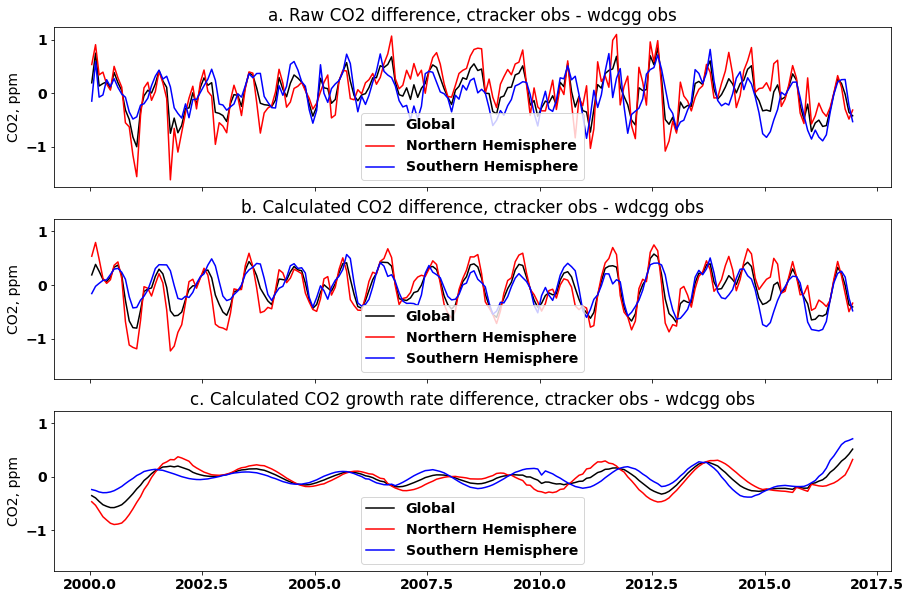

In [35]:
# 1.2. Plot the difference in global, NH and SH area-weighted average CO2 concentration
fig,axis = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize = (15, 10))
(ax1, ax2, ax3) = axis

ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_raw-co2_monthly_wdcgg.global_raw,"k", label = "Global")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_raw-co2_monthly_wdcgg.NH_raw,"r", label = "Northern Hemisphere")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_raw-co2_monthly_wdcgg.SH_raw,"b", label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw CO2 difference, ctracker obs - wdcgg obs")

ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_cal-co2_monthly_wdcgg.global_cal,"k", label = "Global")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_cal-co2_monthly_wdcgg.NH_cal,"r", label = "Northern Hemisphere")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_cal-co2_monthly_wdcgg.SH_cal,"b", label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated CO2 difference, ctracker obs - wdcgg obs")

ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_co2rate-co2_monthly_wdcgg.global_co2rate,"k", label = "Global")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_co2rate-co2_monthly_wdcgg.NH_co2rate,"r", label = "Northern Hemisphere")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_co2rate-co2_monthly_wdcgg.SH_co2rate,"b", label = "Southern Hemisphere")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated CO2 growth rate difference, ctracker obs - wdcgg obs");

plt.savefig("figure7.png")

In [36]:
diff_annaul  = (co2_annual_ctracker-co2_annual_wdcgg).T
diff_annaul

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate
year,,,,,,,,,
2000,0.046862,0.080370,0.013354,0.023550,0.002527,0.044572,-0.470963,-0.731306,-0.210620
2001,-0.194281,-0.386877,-0.001686,-0.210415,-0.466334,0.045504,0.069320,0.047631,0.091010
2002,-0.148046,-0.239461,-0.056631,-0.093601,-0.239194,0.051991,0.062643,0.147119,-0.021834
2003,-0.061461,-0.159239,0.036317,-0.043985,-0.147956,0.059985,0.115277,0.164139,0.066415
2004,0.032939,0.005689,0.060190,0.023967,-0.000676,0.048611,-0.075250,-0.055197,-0.095304
2005,0.095299,0.034082,0.156516,-0.005467,-0.064381,0.053447,0.017289,-0.015555,0.050134
2006,0.247018,0.342658,0.151379,0.051524,0.109783,-0.006734,-0.082547,-0.063580,-0.101513
2007,0.170197,0.373716,-0.033321,-0.009738,0.038888,-0.058364,-0.031332,-0.128648,0.065984
2008,0.171179,0.390875,-0.048517,-0.049637,-0.020011,-0.079263,-0.081225,-0.014001,-0.148449


In [37]:
diff_monthly = co2_monthly_ctracker-co2_monthly_wdcgg
diff_monthly
diff_monthly.agg(["mean", "std"])

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate,year
mean,0.007150,0.045385,-0.031085,-0.059099,-0.064904,-0.053295,-0.043920,-0.071082,-0.016758,0.0
std,0.339997,0.471163,0.358826,0.319401,0.426670,0.316451,0.180115,0.253770,0.178128,0.0


<a name="ctracker_model_wdcgg_obs"></a>
# 2. The NOAA method applied to different data sources (ctracker model and wdcgg observation) in 129 common stations, 2000-2017

In [38]:
# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

# read data, and format lon and lat to float with two decimals
df_wdcgg_raw = pd.read_csv(WDCGG_PATH + "df_co2_raw_wdcgg_obs_noaa_from2000.csv")
df_wdcgg_cal = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_noaa_from2000.csv")
df_wdcgg_co2rate = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_noaa_from2000.csv")

df_ctracker_raw = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_raw_ctracker_model_129p.csv")
df_ctracker_cal = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_cal_ctracker_model_129p.csv")
df_ctracker_co2rate = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2rate_cal_ctracker_model_129p.csv")


In [39]:
# 2.1. Calculate zonal and global co2 average over each 30 degree latitudinal band using common 129 stations
# zonal mean
zonal_deg = 30

df_zonal_raw_ctracker = zonal_mean(df_ctracker_raw, zonal_deg, df_ctracker_raw.columns[4:], "lat")
df_zonal_cal_ctracker = zonal_mean(df_ctracker_cal, zonal_deg, df_ctracker_cal.columns[4:], "lat")
df_zonal_co2rate_ctracker = zonal_mean(df_ctracker_co2rate, zonal_deg, df_ctracker_co2rate.columns[4:], "lat")
df_zonal_raw_wdcgg = zonal_mean(df_wdcgg_raw, zonal_deg, df_wdcgg_raw.columns[4:], "lat")
df_zonal_cal_wdcgg = zonal_mean(df_wdcgg_cal, zonal_deg, df_wdcgg_cal.columns[4:], "lat")
df_zonal_co2rate_wdcgg = zonal_mean(df_wdcgg_co2rate, zonal_deg, df_wdcgg_co2rate.columns[4:], "lat")

# nan index, some zonal band can be no observation data
nanindex_raw_ctracker  = df_zonal_raw_ctracker.apply(np.isnan)
nanindex_cal_ctracker  = df_zonal_cal_ctracker.apply(np.isnan)
nanindex_co2rate_ctracker  = df_zonal_co2rate_ctracker.apply(np.isnan)
nanindex_raw_wdcgg  = df_zonal_raw_wdcgg.apply(np.isnan)
nanindex_cal_wdcgg  = df_zonal_cal_wdcgg.apply(np.isnan)
nanindex_co2rate_wdcgg  = df_zonal_co2rate_wdcgg.apply(np.isnan)

nanindex_raw = nanindex_raw_wdcgg | nanindex_raw_ctracker
nanindex_cal = nanindex_cal_wdcgg | nanindex_cal_ctracker
nanindex_co2rate = nanindex_co2rate_wdcgg | nanindex_co2rate_ctracker

df_zonal_raw_ctracker = df_zonal_raw_ctracker[~nanindex_raw]
df_zonal_cal_ctracker = df_zonal_cal_ctracker[~nanindex_cal]
df_zonal_co2rate_ctracker = df_zonal_co2rate_ctracker[~nanindex_co2rate]
df_zonal_raw_wdcgg = df_zonal_raw_wdcgg[~nanindex_raw]
df_zonal_cal_wdcgg = df_zonal_cal_wdcgg[~nanindex_cal]
df_zonal_co2rate_wdcgg = df_zonal_co2rate_wdcgg[~nanindex_co2rate]

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_raw_ctracker.index)
NH_weight = NH_weight.set_axis(df_zonal_raw_ctracker.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw_ctracker.index[3:])

# global area weighted average, ctracker
global_co2_raw = df_zonal_raw_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_ctracker = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                                 global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_ctracker.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                               "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_ctracker["year"] = df_datetime.date.dt.year.tolist()

co2_annual_ctracker = co2_monthly_ctracker.groupby(["year"]).mean().T

# global area weighted average, wdcgg
global_co2_raw = df_zonal_raw_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_wdcgg = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                              global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_wdcgg.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                            "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_wdcgg["year"] = df_datetime.date.dt.year.tolist()

co2_annual_wdcgg = co2_monthly_wdcgg.groupby(["year"]).mean().T


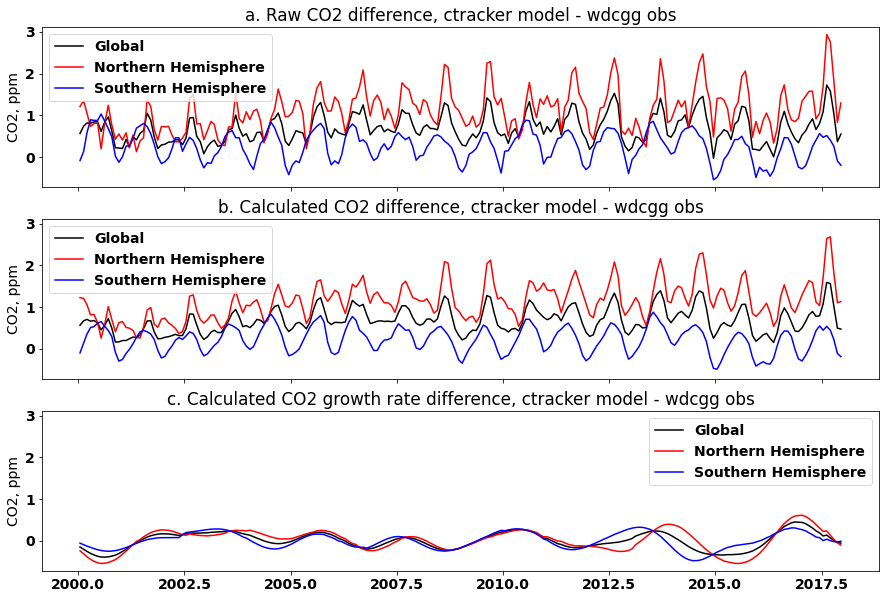

In [40]:
# 2.2 Plot the difference in global, NH and SH area-weighted average CO2 concentration
fig,axis = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize = (15, 10))
(ax1, ax2, ax3) = axis

ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_raw-co2_monthly_wdcgg.global_raw,"k", label = "Global")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_raw-co2_monthly_wdcgg.NH_raw,"r", label = "Northern Hemisphere")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_raw-co2_monthly_wdcgg.SH_raw,"b", label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw CO2 difference, ctracker model - wdcgg obs")

ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_cal-co2_monthly_wdcgg.global_cal,"k", label = "Global")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_cal-co2_monthly_wdcgg.NH_cal,"r", label = "Northern Hemisphere")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_cal-co2_monthly_wdcgg.SH_cal,"b", label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated CO2 difference, ctracker model - wdcgg obs")

ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_co2rate-co2_monthly_wdcgg.global_co2rate,"k", label = "Global")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_co2rate-co2_monthly_wdcgg.NH_co2rate,"r", label = "Northern Hemisphere")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_co2rate-co2_monthly_wdcgg.SH_co2rate,"b", label = "Southern Hemisphere")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated CO2 growth rate difference, ctracker model - wdcgg obs")

plt.savefig("figure8.png")

In [41]:
diff_annaul  = (co2_annual_ctracker-co2_annual_wdcgg).T
diff_annaul

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate
year,,,,,,,,,
2000,0.676064,0.831405,0.520723,0.542448,0.781717,0.303179,-0.314609,-0.442215,-0.187003
2001,0.491559,0.592185,0.390932,0.356738,0.577284,0.136193,0.000218,0.031002,-0.030566
2002,0.453930,0.724782,0.183077,0.433092,0.723860,0.142324,0.167541,0.176925,0.158157
2003,0.502922,0.756947,0.248897,0.567106,0.858918,0.275295,0.206001,0.193704,0.218298
2004,0.606008,0.990565,0.221451,0.713008,1.064642,0.361375,-0.000823,0.124791,-0.126437
2005,0.720981,1.154282,0.287680,0.747273,1.182442,0.312104,0.134071,0.178958,0.089185
2006,0.801966,1.303124,0.300809,0.822088,1.334278,0.309898,-0.080259,-0.065115,-0.095404
2007,0.780148,1.261042,0.299255,0.770077,1.240152,0.300001,0.006146,-0.029599,0.041892
2008,0.781809,1.323847,0.239772,0.756381,1.279504,0.233258,-0.152306,-0.116171,-0.188441


In [42]:
diff_monthly = co2_monthly_ctracker-co2_monthly_wdcgg
diff_monthly
diff_monthly.agg(["mean", "std"])

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate,year
mean,0.688090,1.111311,0.264869,0.685203,1.145559,0.224847,0.008924,0.015594,0.002254,0.0
std,0.331656,0.515110,0.344955,0.297535,0.435112,0.304336,0.194789,0.256481,0.189720,0.0


<a name="ctracker_model_ctracker_obs"></a>
# 3. The NOAA method applied to different data sources (ctracker model and ctracker observation) in 182 common stations, 2000-2017

In [43]:
# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

# read data, and format lon and lat to float with two decimals
df_ctracker_obs_raw = pd.read_csv(CTRACKER_OBS_PATH + "df_co2_raw_ctracker_obs.csv")
df_ctracker_obs_cal = pd.read_csv(CTRACKER_OBS_PATH + "df_co2_cal_ctracker_obs.csv")
df_ctracker_obs_co2rate = pd.read_csv(CTRACKER_OBS_PATH + "df_co2rate_cal_ctracker_obs.csv")

df_ctracker_model_raw = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_raw_ctracker_model_182p.csv")
df_ctracker_model_cal = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_cal_ctracker_model_182p.csv")
df_ctracker_model_co2rate = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2rate_cal_ctracker_model_182p.csv")


In [44]:
# 3.1. Calculate zonal and global co2 average over each 30 degree latitudinal band using common 182 stations
# zonal mean
zonal_deg = 30

df_zonal_raw_ctracker_obs = zonal_mean(df_ctracker_obs_raw, zonal_deg, df_ctracker_obs_raw.columns[4:], "lat")
df_zonal_cal_ctracker_obs = zonal_mean(df_ctracker_obs_cal, zonal_deg, df_ctracker_obs_cal.columns[4:], "lat")
df_zonal_co2rate_ctracker_obs = zonal_mean(df_ctracker_obs_co2rate, zonal_deg, df_ctracker_obs_co2rate.columns[4:], "lat")
df_zonal_raw_ctracker_model = zonal_mean(df_ctracker_model_raw, zonal_deg, df_ctracker_model_raw.columns[4:], "lat")
df_zonal_cal_ctracker_model = zonal_mean(df_ctracker_model_cal, zonal_deg, df_ctracker_model_cal.columns[4:], "lat")
df_zonal_co2rate_ctracker_model = zonal_mean(df_ctracker_model_co2rate, zonal_deg, df_ctracker_model_co2rate.columns[4:], "lat")

# nan index, some zonal band can be no observation data
nanindex_raw_ctracker_obs  = df_zonal_raw_ctracker_obs.apply(np.isnan)
nanindex_cal_ctracker_obs  = df_zonal_cal_ctracker_obs.apply(np.isnan)
nanindex_co2rate_ctracker_obs  = df_zonal_co2rate_ctracker_obs.apply(np.isnan)
nanindex_raw_ctracker_model  = df_zonal_raw_ctracker_model.apply(np.isnan)
nanindex_cal_ctracker_model  = df_zonal_cal_ctracker_model.apply(np.isnan)
nanindex_co2rate_ctracker_model  = df_zonal_co2rate_ctracker_model.apply(np.isnan)

nanindex_raw = nanindex_raw_ctracker_obs | nanindex_raw_ctracker_model
nanindex_cal = nanindex_cal_ctracker_obs | nanindex_cal_ctracker_model
nanindex_co2rate = nanindex_co2rate_ctracker_obs | nanindex_co2rate_ctracker_model

df_zonal_raw_ctracker_obs = df_zonal_raw_ctracker_obs[~nanindex_raw]
df_zonal_cal_ctracker_obs = df_zonal_cal_ctracker_obs[~nanindex_cal]
df_zonal_co2rate_ctracker_obs = df_zonal_co2rate_ctracker_obs[~nanindex_co2rate]
df_zonal_raw_ctracker_model = df_zonal_raw_ctracker_model[~nanindex_raw]
df_zonal_cal_ctracker_model = df_zonal_cal_ctracker_model[~nanindex_cal]
df_zonal_co2rate_ctracker_model = df_zonal_co2rate_ctracker_model[~nanindex_co2rate]

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_raw_ctracker_obs.index)
NH_weight = NH_weight.set_axis(df_zonal_raw_ctracker_obs.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw_ctracker_obs.index[3:])

# global area weighted average, ctracker observation
global_co2_raw = df_zonal_raw_ctracker_obs.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_ctracker_obs.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_ctracker_obs.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_ctracker_obs.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_ctracker_obs.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_ctracker_obs.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_ctracker_obs.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_ctracker_obs.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_ctracker_obs.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_ctracker_obs = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                                 global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_ctracker_obs.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                               "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_ctracker_obs["year"] = df_datetime.date.dt.year.tolist()

co2_annual_ctracker_obs = co2_monthly_ctracker_obs.groupby(["year"]).mean().T

# global area weighted average, ctracker model
global_co2_raw = df_zonal_raw_ctracker_model.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_ctracker_model.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_ctracker_model.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_ctracker_model.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_ctracker_model.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_ctracker_model.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_ctracker_model.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_ctracker_model.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_ctracker_model.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_ctracker_model = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                              global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_ctracker_model.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                            "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_ctracker_model["year"] = df_datetime.date.dt.year.tolist()

co2_annual_ctracker_model = co2_monthly_ctracker_model.groupby(["year"]).mean().T


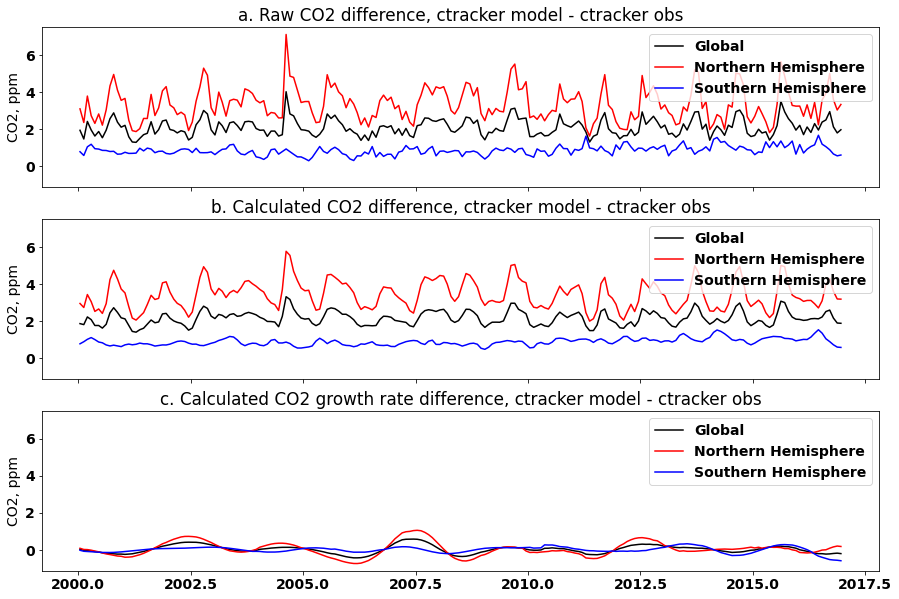

In [45]:
# 3.2 Plot the difference in global, NH and SH area-weighted average CO2 concentration
fig,axis = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize = (15, 10))
(ax1, ax2, ax3) = axis

ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.global_raw-co2_monthly_ctracker_obs.global_raw,"k", label = "Global")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.NH_raw-co2_monthly_ctracker_obs.NH_raw,"r", label = "Northern Hemisphere")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.SH_raw-co2_monthly_ctracker_obs.SH_raw,"b", label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw CO2 difference, ctracker model - ctracker obs")

ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.global_cal-co2_monthly_ctracker_obs.global_cal,"k", label = "Global")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.NH_cal-co2_monthly_ctracker_obs.NH_cal,"r", label = "Northern Hemisphere")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.SH_cal-co2_monthly_ctracker_obs.SH_cal,"b", label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated CO2 difference, ctracker model - ctracker obs")

ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.global_co2rate-co2_monthly_ctracker_obs.global_co2rate,"k", label = "Global")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.NH_co2rate-co2_monthly_ctracker_obs.NH_co2rate,"r", label = "Northern Hemisphere")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker_model.SH_co2rate-co2_monthly_ctracker_obs.SH_co2rate,"b", label = "Southern Hemisphere")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated CO2 growth rate difference, ctracker model - ctracker obs")

plt.savefig("figure8.png")

In [46]:
diff_annaul  = (co2_annual_ctracker_model-co2_annual_ctracker_obs).T
diff_annaul

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate
year,,,,,,,,,
2000,2.062281,3.280497,0.844064,2.064726,3.308536,0.820916,-0.118044,-0.132393,-0.103696
2001,1.871850,2.940863,0.802838,1.870694,3.008635,0.732753,-0.027284,-0.072556,0.017988
2002,2.087600,3.370364,0.804836,2.103245,3.410964,0.795525,0.368765,0.621767,0.115764
2003,2.187962,3.554103,0.821821,2.326467,3.735060,0.917874,0.027653,0.011064,0.044242
2004,2.209475,3.752023,0.666926,2.322124,3.882787,0.761461,0.109901,0.274485,-0.054682
2005,2.134053,3.545565,0.722541,2.272568,3.732401,0.812735,-0.125979,-0.313427,0.061468
2006,1.848074,3.078690,0.617459,1.974110,3.230626,0.717594,-0.209593,-0.373155,-0.046031
2007,2.102903,3.374030,0.831776,2.172330,3.506020,0.838641,0.465820,0.863112,0.068527
2008,2.254532,3.751923,0.757140,2.323957,3.901035,0.746878,-0.219252,-0.337228,-0.101276


In [47]:
diff_monthly = co2_monthly_ctracker_model-co2_monthly_ctracker_obs
diff_monthly
diff_monthly.agg(["mean", "std"])

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate,year
mean,2.100937,3.348242,0.853632,2.154582,3.428659,0.880506,0.032985,0.052519,0.013451,0.0
std,0.448790,0.891224,0.241180,0.366809,0.746688,0.189594,0.218106,0.377825,0.164088,0.0


<a name="noaa_mikio_wdcgg"></a>
# 4. The different methods (NOAA and Mikio) applied to the WDCGG observation at 129 stations, 1968-2017

In [48]:
# read data
df_co2_cal_wdcgg_noaa = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_noaa.csv")
df_co2rate_cal_wdcgg_noaa = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv")

df_co2_cal_wdcgg_mikio = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_mikio.csv")
df_co2rate_cal_wdcgg_mikio = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_mikio.csv")

# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='1968-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

In [49]:
# 4.1 Calculate zonal and global co2 average over each 30 degree latitudinal band using WDCGG 129 stations# 
# read data
df_co2_cal_wdcgg_noaa = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_noaa.csv")
df_co2_cal_wdcgg_mikio = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_mikio.csv")
df_co2rate_cal_wdcgg_noaa = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv")
df_co2rate_cal_wdcgg_mikio = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_mikio.csv")

# zonal mean
zonal_deg = 30

df_zonal_cal_noaa = zonal_mean(df_co2_cal_wdcgg_noaa, zonal_deg, df_co2_cal_wdcgg_noaa.columns[4:], "lat")
df_zonal_cal_mikio = zonal_mean(df_co2_cal_wdcgg_mikio, zonal_deg, df_co2_cal_wdcgg_mikio.columns[4:], "lat")
df_zonal_co2rate_noaa = zonal_mean(df_co2rate_cal_wdcgg_noaa, zonal_deg, df_co2rate_cal_wdcgg_noaa.columns[4:], "lat")
df_zonal_co2rate_mikio = zonal_mean(df_co2rate_cal_wdcgg_mikio, zonal_deg, df_co2rate_cal_wdcgg_mikio.columns[4:], "lat")

# nan index, some zonal band can be no observation data
nanindex_cal_noaa = df_zonal_cal_noaa.apply(np.isnan)
nanindex_cal_mikio = df_zonal_cal_mikio.apply(np.isnan)
nanindex_co2rate_noaa = df_zonal_co2rate_noaa.apply(np.isnan)
nanindex_co2rate_mikio = df_zonal_co2rate_mikio.apply(np.isnan)

nanindex_cal = nanindex_cal_noaa | nanindex_cal_mikio
nanindex_co2rate = nanindex_co2rate_noaa | nanindex_co2rate_mikio

df_zonal_cal_noaa = df_zonal_cal_noaa[~nanindex_cal]
df_zonal_cal_mikio = df_zonal_cal_mikio[~nanindex_cal]
df_zonal_co2rate_noaa = df_zonal_co2rate_noaa[~nanindex_co2rate]
df_zonal_co2rate_mikio = df_zonal_co2rate_mikio[~nanindex_co2rate]

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_cal_noaa.index)
NH_weight = NH_weight.set_axis(df_zonal_cal_noaa.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_cal_noaa.index[3:])

# global area weighted average, noaa
global_co2_cal = df_zonal_cal_noaa.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_noaa.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_noaa.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_noaa.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_noaa.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_noaa.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_noaa = pd.concat([global_co2_cal,NH_co2_cal,SH_co2_cal,global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_noaa.columns = ["global_cal","NH_cal","SH_cal","global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_noaa["year"] = df_datetime.date.dt.year.tolist()

co2_annual_noaa = co2_monthly_noaa.groupby(["year"]).mean().T

# global area weighted average, mikio
global_co2_cal = df_zonal_cal_mikio.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_mikio.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_mikio.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_mikio.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_mikio.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_mikio.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_mikio = pd.concat([global_co2_cal,NH_co2_cal,SH_co2_cal,global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_mikio.columns = ["global_cal","NH_cal","SH_cal","global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_mikio["year"] = df_datetime.date.dt.year.tolist()

co2_annual_mikio = co2_monthly_mikio.groupby(["year"]).mean().T

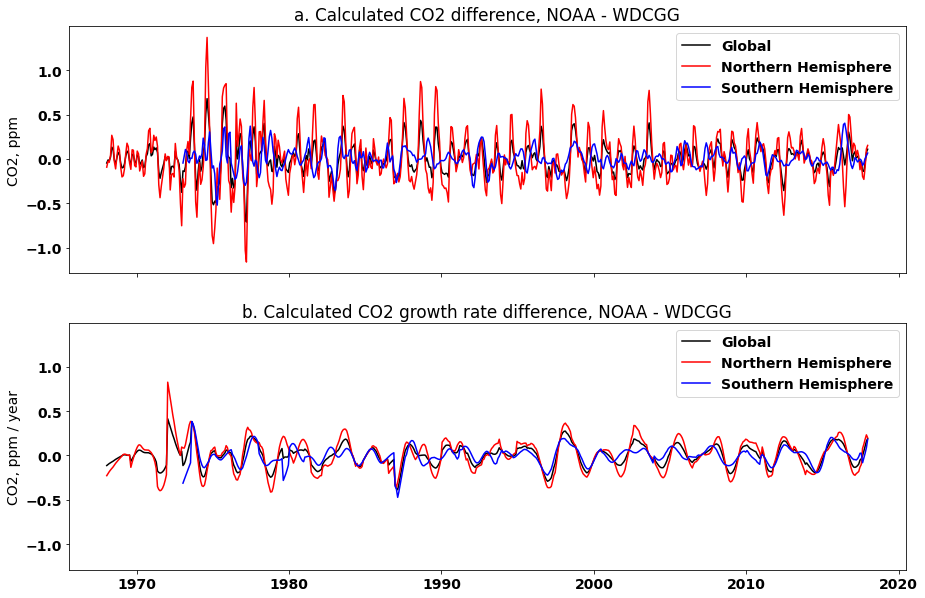

In [50]:
# 4.2 Plot the difference in global, NH and SH area-weighted average CO2 concentration
fig,axis = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15, 10))
(ax1, ax2) = axis

ax1.plot(df_datetime.decimalyear, co2_monthly_noaa.global_cal-co2_monthly_mikio.global_cal,"k", label = "Global")
ax1.plot(df_datetime.decimalyear, co2_monthly_noaa.NH_cal-co2_monthly_mikio.NH_cal,"r", label = "Northern Hemisphere")
ax1.plot(df_datetime.decimalyear, co2_monthly_noaa.SH_cal-co2_monthly_mikio.SH_cal,"b", label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Calculated CO2 difference, NOAA - WDCGG")

ax2.plot(df_datetime.decimalyear, co2_monthly_noaa.global_co2rate-co2_monthly_mikio.global_co2rate,"k", label = "Global")
ax2.plot(df_datetime.decimalyear, co2_monthly_noaa.NH_co2rate-co2_monthly_mikio.NH_co2rate,"r", label = "Northern Hemisphere")
ax2.plot(df_datetime.decimalyear, co2_monthly_noaa.SH_co2rate-co2_monthly_mikio.SH_co2rate,"b", label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm / year")
ax2.legend()
ax2.set_title("b. Calculated CO2 growth rate difference, NOAA - WDCGG")

plt.savefig("figure9.png")

In [51]:
diff_annaul  = (co2_annual_noaa-co2_annual_mikio).T
diff_annaul.iloc[12:,:]

,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate
year,,,,,,
1980,0.031391,0.036934,0.025847,0.050370,0.051091,0.049650
1981,0.031009,0.073117,-0.011099,-0.073941,-0.101351,-0.046531
1982,-0.055959,-0.084403,-0.027516,-0.051773,-0.120500,0.016954
1983,0.006973,-0.025760,0.039705,0.116016,0.203607,0.028424
1984,0.010221,0.025754,-0.005313,-0.064344,-0.067433,-0.061254
1985,-0.017657,-0.013651,-0.021664,0.036611,0.054849,0.018373
1986,-0.001909,0.011901,-0.015719,-0.091134,-0.127631,-0.054637
1987,0.027658,0.037408,0.017908,-0.092003,-0.036390,-0.147616
1988,0.062375,0.105985,0.018764,0.026834,0.044917,0.008751


In [52]:
diff_monthly = co2_monthly_noaa.iloc[12:,:]-co2_monthly_mikio.iloc[12:,:]
diff_monthly
diff_monthly.agg(["mean", "std"])

,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate,year
mean,-0.001532,-0.003707,0.000701,0.000128,0.006949,-0.007289,0.0
std,0.167116,0.303189,0.117371,0.117750,0.175814,0.098426,0.0


<a name="noaa_mikio_ctracker_wdcgg"></a>
# 5. The different methods (NOAA and WDCGG) applied to the different data sources (ctracker model and wdcgg observation) in 129 common stations, 2000-2017

In [53]:
# orginaze full monthly time series from 2000 to 2017
df_datetime = pd.DataFrame()
df_datetime["date"] = pd.date_range(start='2000-01-01', end='2017-12-31', freq="M")
df_datetime.date = df_datetime.date.apply(lambda dt: dt.replace(day=15))
df_datetime['decimalyear'] = decimalDate_ymd( df_datetime.date.dt.year,  df_datetime.date.dt.month, 15)

# read data, and format lon and lat to float with two decimals
df_wdcgg_raw = pd.read_csv(WDCGG_PATH + "df_co2_raw_wdcgg_obs_noaa.csv")
cols = df_wdcgg_raw.columns.to_list()
drop_cols = cols[4:388]
df_wdcgg_raw = df_wdcgg_raw.drop(columns=drop_cols)

df_wdcgg_cal = pd.read_csv(WDCGG_PATH + "df_co2_cal_wdcgg_obs_noaa.csv")
df_wdcgg_cal = df_wdcgg_cal.drop(columns=drop_cols)

df_wdcgg_co2rate = pd.read_csv(WDCGG_PATH + "df_co2rate_cal_wdcgg_obs_noaa.csv")
df_wdcgg_co2rate = df_wdcgg_co2rate.drop(columns=drop_cols)

df_ctracker_raw = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_raw_ctracker_model_129p.csv")
df_ctracker_cal = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2_cal_ctracker_model_129p.csv")
df_ctracker_co2rate = pd.read_csv(CTRACKER_MODEL_PATH + "df_co2rate_cal_ctracker_model_129p.csv")


In [54]:
# 5.1 Calculate zonal and global co2 average over each 30 degree latitudinal band using common 129 stations
# zonal mean
zonal_deg = 30

df_zonal_raw_ctracker = zonal_mean(df_ctracker_raw, zonal_deg, df_ctracker_raw.columns[4:], "lat")
df_zonal_cal_ctracker = zonal_mean(df_ctracker_cal, zonal_deg, df_ctracker_cal.columns[4:], "lat")
df_zonal_co2rate_ctracker = zonal_mean(df_ctracker_co2rate, zonal_deg, df_ctracker_co2rate.columns[4:], "lat")
df_zonal_raw_wdcgg = zonal_mean(df_wdcgg_raw, zonal_deg, df_wdcgg_raw.columns[4:], "lat")
df_zonal_cal_wdcgg = zonal_mean(df_wdcgg_cal, zonal_deg, df_wdcgg_cal.columns[4:], "lat")
df_zonal_co2rate_wdcgg = zonal_mean(df_wdcgg_co2rate, zonal_deg, df_wdcgg_co2rate.columns[4:], "lat")

# nan index, some zonal band can be no observation data
nanindex_raw_ctracker  = df_zonal_raw_ctracker.apply(np.isnan)
nanindex_cal_ctracker  = df_zonal_cal_ctracker.apply(np.isnan)
nanindex_co2rate_ctracker  = df_zonal_co2rate_ctracker.apply(np.isnan)
nanindex_raw_wdcgg  = df_zonal_raw_wdcgg.apply(np.isnan)
nanindex_cal_wdcgg  = df_zonal_cal_wdcgg.apply(np.isnan)
nanindex_co2rate_wdcgg  = df_zonal_co2rate_wdcgg.apply(np.isnan)

nanindex_raw = nanindex_raw_wdcgg | nanindex_raw_ctracker
nanindex_cal = nanindex_cal_wdcgg | nanindex_cal_ctracker
nanindex_co2rate = nanindex_co2rate_wdcgg | nanindex_co2rate_ctracker

df_zonal_raw_ctracker = df_zonal_raw_ctracker[~nanindex_raw]
df_zonal_cal_ctracker = df_zonal_cal_ctracker[~nanindex_cal]
df_zonal_co2rate_ctracker = df_zonal_co2rate_ctracker[~nanindex_co2rate]
df_zonal_raw_wdcgg = df_zonal_raw_wdcgg[~nanindex_raw]
df_zonal_cal_wdcgg = df_zonal_cal_wdcgg[~nanindex_cal]
df_zonal_co2rate_wdcgg = df_zonal_co2rate_wdcgg[~nanindex_co2rate]

# area weight
df_area = pd.DataFrame(grid_area(0.5))
area_lat = df_area.iloc[:,0]
area_zonal = area_lat.groupby(np.arange(len(area_lat))//(zonal_deg/0.5)).sum()

global_weight = area_zonal/area_zonal.sum()
NH_weight = area_zonal[:len(area_zonal)/2-1] /(area_zonal.sum()/2)
SH_weight = area_zonal[len(area_zonal)/2:] /(area_zonal.sum()/2)

global_weight = global_weight.set_axis(df_zonal_raw_ctracker.index)
NH_weight = NH_weight.set_axis(df_zonal_raw_ctracker.index[:3])
SH_weight = SH_weight.set_axis(df_zonal_raw_ctracker.index[3:])

# global area weighted average, ctracker
global_co2_raw = df_zonal_raw_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_ctracker.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_ctracker.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_ctracker.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_ctracker = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                                 global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_ctracker.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                               "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_ctracker["year"] = df_datetime.date.dt.year.tolist()

co2_annual_ctracker = co2_monthly_ctracker.groupby(["year"]).mean().T

# global area weighted average, wdcgg
global_co2_raw = df_zonal_raw_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_raw = df_zonal_raw_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_raw = df_zonal_raw_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2_cal = df_zonal_cal_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2_cal = df_zonal_cal_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2_cal = df_zonal_cal_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

global_co2rate = df_zonal_co2rate_wdcgg.mul(global_weight, axis = 0).sum(min_count=1)
NH_co2rate = df_zonal_co2rate_wdcgg.iloc[:3,:].mul(NH_weight, axis = 0).sum(min_count=1)
SH_co2rate = df_zonal_co2rate_wdcgg.iloc[3:,:].mul(SH_weight, axis = 0).sum(min_count=1)

co2_monthly_wdcgg = pd.concat([global_co2_raw,NH_co2_raw,SH_co2_raw,global_co2_cal,NH_co2_cal,SH_co2_cal,
                              global_co2rate,NH_co2rate,SH_co2rate],axis=1)
co2_monthly_wdcgg.columns = ["global_raw","NH_raw","SH_raw","global_cal","NH_cal","SH_cal",
                            "global_co2rate","NH_co2rate","SH_co2rate"]
co2_monthly_wdcgg["year"] = df_datetime.date.dt.year.tolist()

co2_annual_wdcgg = co2_monthly_wdcgg.groupby(["year"]).mean().T


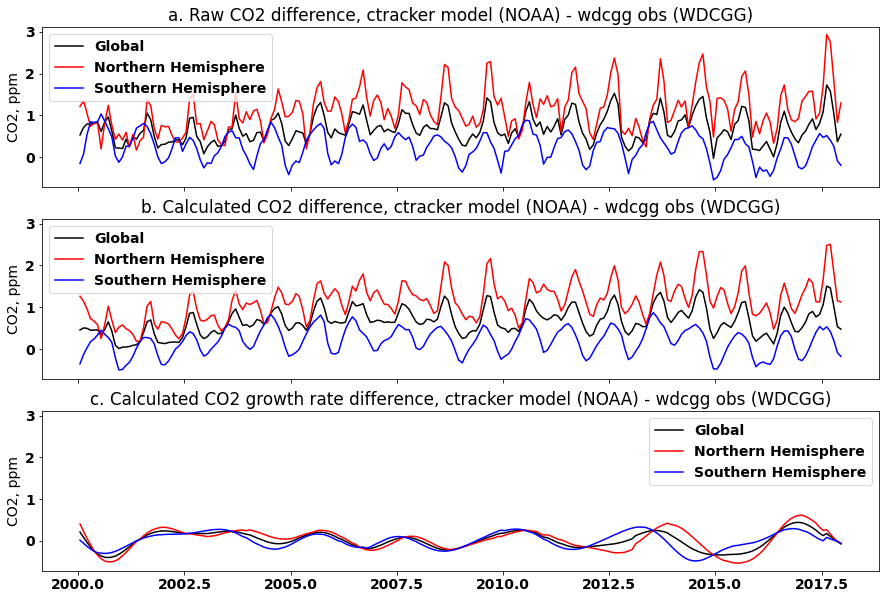

In [55]:
# 5.2 Plot the difference in global, NH and SH area-weighted average CO2 concentration
fig,axis = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize = (15, 10))
(ax1, ax2, ax3) = axis

ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_raw-co2_monthly_wdcgg.global_raw,"k", label = "Global")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_raw-co2_monthly_wdcgg.NH_raw,"r", label = "Northern Hemisphere")
ax1.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_raw-co2_monthly_wdcgg.SH_raw,"b", label = "Southern Hemisphere")
ax1.set_ylabel("CO2, ppm")
ax1.legend()
ax1.set_title("a. Raw CO2 difference, ctracker model (NOAA) - wdcgg obs (WDCGG)")

ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_cal-co2_monthly_wdcgg.global_cal,"k", label = "Global")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_cal-co2_monthly_wdcgg.NH_cal,"r", label = "Northern Hemisphere")
ax2.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_cal-co2_monthly_wdcgg.SH_cal,"b", label = "Southern Hemisphere")
ax2.set_ylabel("CO2, ppm")
ax2.legend()
ax2.set_title("b. Calculated CO2 difference, ctracker model (NOAA) - wdcgg obs (WDCGG)")

ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.global_co2rate-co2_monthly_wdcgg.global_co2rate,"k", label = "Global")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.NH_co2rate-co2_monthly_wdcgg.NH_co2rate,"r", label = "Northern Hemisphere")
ax3.plot(df_datetime.decimalyear, co2_monthly_ctracker.SH_co2rate-co2_monthly_wdcgg.SH_co2rate,"b", label = "Southern Hemisphere")
ax3.set_ylabel("CO2, ppm")
ax3.legend()
ax3.set_title("c. Calculated CO2 growth rate difference, ctracker model (NOAA) - wdcgg obs (WDCGG)")

plt.savefig("figure10.png")

In [56]:
diff_annaul  = (co2_annual_ctracker-co2_annual_wdcgg).T
diff_annaul

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate
year,,,,,,,,,
2000,0.663650,0.831405,0.495895,0.402018,0.734399,0.069637,-0.221588,-0.232659,-0.210518
2001,0.500638,0.610344,0.390932,0.244390,0.553438,-0.064658,0.036634,0.047687,0.025582
2002,0.453930,0.724782,0.183077,0.374243,0.701896,0.046590,0.195382,0.209889,0.180875
2003,0.502922,0.756947,0.248897,0.563185,0.853509,0.272862,0.203396,0.190412,0.216380
2004,0.606008,0.990565,0.221451,0.705713,1.050069,0.361357,0.001120,0.129335,-0.127094
2005,0.720981,1.154282,0.287680,0.742450,1.174203,0.310698,0.135873,0.180489,0.091256
2006,0.801966,1.303124,0.300809,0.821649,1.332088,0.311210,-0.076416,-0.056865,-0.095967
2007,0.780148,1.261042,0.299255,0.775660,1.249151,0.302169,0.011975,-0.019332,0.043281
2008,0.781809,1.323847,0.239772,0.763568,1.293306,0.233829,-0.145738,-0.101338,-0.190138


In [57]:
diff_monthly = co2_monthly_ctracker-co2_monthly_wdcgg
diff_monthly
diff_monthly.agg(["mean", "std"])

,global_raw,NH_raw,SH_raw,global_cal,NH_cal,SH_cal,global_co2rate,NH_co2rate,SH_co2rate,year
mean,0.687905,1.112320,0.263490,0.666741,1.138122,0.195359,0.017798,0.030673,0.004923,0.0
std,0.331210,0.514021,0.344233,0.313105,0.443338,0.317029,0.193265,0.252302,0.192786,0.0
